<a href="https://colab.research.google.com/github/ChromaCodeASMR/Binary_Classification_PyTorch/blob/main/BinaryClassificationPyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')
!cp '/content/drive/MyDrive/NovKaggle/test.csv.zip' '/content/test.csv.zip'

Mounted at /content/drive


In [2]:
!cp '/content/drive/MyDrive/NovKaggle/train.csv.zip' '/content/train.csv.zip'
!cp '/content/drive/MyDrive/NovKaggle/sample_submission.csv.zip' '/content/sample_submission.csv.zip'

In [3]:
!unzip -q test.csv.zip -d /content/
!unzip -q train.csv.zip -d /content/
!unzip -q sample_submission.csv.zip -d /content/

# Data Exploration

In [4]:
import pandas as pd

In [5]:
train_df = pd.read_csv('/content/train.csv', index_col='id')

In [6]:
print("Number of columns (incl. target):", len(train_df.columns))
print("Number of rows:", len(train_df))

Number of columns (incl. target): 101
Number of rows: 600000


In [7]:
train_df['target']

id
0         0
1         0
2         0
3         0
4         1
         ..
599995    1
599996    0
599997    0
599998    1
599999    1
Name: target, Length: 600000, dtype: int64

In [8]:
train_df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.106643,3.59437,132.8040,3.18428,0.081971,1.18859,3.73238,2.266270,2.09959,0.012330,1.607190,-0.318058,0.560137,2.806880,1.35114,2.535930,0.197527,0.676494,1.98979,-3.842450,0.037380,0.230322,3.33055,0.009397,0.144738,3.05131,1.30362,0.033225,-0.018284,2.748210,-0.009294,-0.036271,-0.049871,0.019484,3.898460,11.2863,1.138020,3.366880,4.94446,-0.105772,...,-0.027551,0.019483,-0.048826,0.050748,3.729300,5.017440,4.186880,0.063342,0.121043,1.37175,4.017450,0.167613,0.039754,2.042360,-0.016614,0.107679,3.507250,0.013660,-0.097023,5.396070,0.244457,3.49184,0.113090,-0.015472,4.208790,4.106560,0.037227,-0.118814,0.067086,0.010739,1.09862,0.013331,-0.011715,0.052759,0.065400,4.211250,1.97877,0.085974,0.240496,0
1,0.125021,1.67336,76.5336,3.37825,0.099400,5.09366,1.27562,-0.471318,4.54594,0.037706,0.331749,0.325091,0.062040,2.262150,4.33943,-0.224999,0.233586,3.381280,1.90299,0.067874,-0.051268,0.006135,2.60444,0.103441,0.067638,4.75362,1.85552,-0.181834,0.008359,3.166340,0.011850,0.022292,0.069320,0.117109,0.315276,24.4807,1.672270,-0.409067,4.95475,0.092358,...,-0.010841,0.064584,0.102548,0.093611,0.964089,0.630422,4.307340,0.091289,-0.036360,3.61767,3.103240,0.000657,0.051302,1.924620,0.123294,-0.022671,1.548120,-0.010397,0.058330,3.661310,-0.118386,2.35739,-0.009112,0.178701,4.097350,3.532890,0.005244,0.121381,0.109968,0.135838,3.46017,0.017054,0.124863,0.154064,0.606848,-0.267928,2.57786,-0.020877,0.024719,0
2,0.036330,1.49747,233.5460,2.19435,0.026914,3.12694,5.05687,3.849460,1.80187,0.056995,0.328684,2.968810,0.105244,2.069490,5.30986,1.354790,-0.262018,1.379080,1.48091,0.020542,-0.008806,0.109348,1.68365,0.038180,0.123716,1.11248,3.57166,0.120601,0.082069,2.233520,0.002270,0.045182,0.014405,0.011599,-0.502849,33.7382,1.417500,1.071350,3.22296,2.122030,...,0.027571,-0.007121,-0.048914,-0.002574,1.865090,2.404170,0.411741,0.057749,0.525174,2.16879,0.828297,0.089848,0.093744,4.949010,-0.010978,0.076671,0.266784,0.038691,0.382731,3.847600,-0.121482,3.74084,0.147098,-0.016566,0.614651,2.125840,0.078828,0.979808,0.026758,0.117310,4.88300,0.085222,0.032396,0.116092,-0.001689,-0.520069,2.14112,0.124464,0.148209,0
3,-0.014077,0.24600,779.9670,1.89064,0.006948,1.53112,2.69800,4.517330,4.50332,0.123494,1.002680,4.869600,0.058411,2.497850,1.23843,2.348360,0.175475,1.608890,2.02881,0.042086,0.005141,0.076506,1.65122,0.111813,0.121641,0.58912,4.23692,-0.032843,0.058168,0.712927,0.097465,0.072744,0.000324,0.063362,4.063820,25.3824,0.576572,2.026210,2.96843,1.085670,...,0.110884,0.026837,2.931160,0.068112,-0.495192,1.345280,2.242750,0.035611,-0.139274,4.74243,3.292740,0.117877,0.065605,0.556711,-0.058029,0.070501,1.101250,0.068559,0.162928,4.070180,-0.008835,3.89678,0.913739,-0.163204,3.074850,4.356780,-0.048894,4.917990,0.069930,-0.015347,3.47439,-0.017103,-0.008100,0.062013,0.041193,0.511657,1.96860,0.040017,0.044873,0
4,-0.003259,3.71542,156.1280,2.14772,0.018284,2.09859,4.15492,-0.038236,3.37145,0.034166,0.711483,0.769988,0.057555,0.957257,3.71145,5.464350,0.287104,2.616950,1.38403,0.074883,-0.010543,0.109121,2.27602,0.008023,0.045236,4.35954,5.07562,-0.009376,0.528966,4.053350,0.020000,0.106828,0.051307,0.045939,3.402460,15.5615,1.635960,0.047029,4.01771,0.155748,...,0.075586,0.032114,-0.042284,0.047974,-0.294184,5.065600,1.050290,0.034019,0.024611,3.12578,2.262840,0.082462,-0.023296,5.615850,0.086238,0.157568,3.725670,0.061247,0.086603,0.607246,1.411090,2.06062,-0.023154,0.011234,2.155530,0.914518,0.044521,0.375731,0.134351,0.013781,1.91059,-0.042943,0.105616,0.125072,0.037509,1.043790,1.07481,-0.012819,0.072798,1


In [9]:
train_df.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,target
count,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,...,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000
mean,0.306508,2.497590,306.644536,2.647901,0.177850,2.556832,2.699650,2.571593,2.538273,0.134370,2.579987,2.759273,0.128958,2.477244,2.662859,2.631040,0.362479,2.483075,2.471319,0.108097,0.093783,0.062157,2.559781,0.097061,0.141055,2.580093,2.459101,0.057945,0.216789,2.471344,0.125638,0.107798,0.170434,0.054776,2.463409,55.698848,1.769510,2.595079,2.410926,0.593497,...,0.144262,0.124303,0.340198,0.086385,2.513444,2.577005,2.522315,0.134467,0.189364,2.494925,2.632673,0.129834,0.050814,2.551266,0.174057,0.231822,2.420256,0.101771,0.349875,2.550175,0.902983,2.598029,0.162773,0.501982,2.587270,2.653461,0.265197,0.335756,0.056866,0.071252,2.444471,0.155260,0.059407,0.144932,0.106419,2.547853,2.590159,0.158881,0.123048,0.506010
std,0.522450,1.554018,551.743893,1.544529,0.417488,1.562527,1.564000,1.549361,1.532988,0.421892,1.604389,1.545217,0.210861,1.517694,1.481966,1.531067,1.346352,1.577456,1.541571,0.395313,0.308938,0.054796,1.556496,0.333590,0.342377,1.609573,1.567891,0.114129,0.339320,1.524330,0.296563,0.412291,0.440615,0.109661,1.566572,130.132892,1.785712,1.562506,1.572078,0.951892,...,0.377962,0.414040,0.623011,0.216007,1.516342,1.563820,1.532317,0.398998,0.744550,1.575232,1.541872,0.308313,0.049142,1.513612,0.641809,1.206276,1.557891,0.245734,0.596830,1.576794,1.335611,1.542775,0.295831,2.364291,1.564173,1.546943,0.562230,0.993598,0.128607,0.112654,1.542509,0.548397,0.119426,0.462015,0.209128,1.558427,1.525091,0.436190,0.264896,0.499964
min,-3.797450,-1.223960,-1842.530000,-1.368560,-3.206210,-1.169770,-1.059310,-1.281970,-1.242020,-2.577840,-1.309730,-1.451570,-0.678145,-1.295160,-1.213890,-1.450540,-18.169600,-1.387720,-1.221020,-5.334110,-2.858550,-0.151519,-1.201070,-2.721660,-2.645250,-1.380430,-1.147260,-2.281050,-4.596700,-1.225650,-2.025710,-3.273000,-1.954520,-3.318420,-1.517720,-397.004000,-2.888940,-1.210370,-1.181050,-2.611230,...,-1.326570,-2.553080,-5.153130,-3.498950,-1.237310,-1.260920,-1.059910,-2.987210,-11.650200,-1.377760,-1.236730,-4.609500,-0.659289,-1.134010,-8.940060,-18.456000,-1.164970,-1.425230,-4.397590,-1.142840,-8.519100,-1.135490,-1.516430,-9.791940,-1.307630,-1.383700,-2.544860,-15.470500,-4.421610,-3.676990,-1.217700,-9.761770,-4.666240,-3.101500,-1.276540,-1.584740,-1.254730,-3.993500,-2.783380,0.000000
25%,0.026222,1.186238,43.573400,1.442028,0.019709,1.261038,1.385820,1.333848,1.292163,0.019563,1.205920,1.520750,0.029119,1.278118,1.504670,1.399320,-0.046389,1.132497,1.218018,0.017039,0.018545,0.027432,1.287208,0.011614,0.017647,1.238715,1.156460,-0.018820,0.057385,1.25

In [10]:
# missing values?
train_df.isnull().any().any()

False

## Split Data

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [12]:
data_features = train_df.drop(['target'], axis=1)
data_targets = train_df['target']

X_train, X_val, y_train, y_val = train_test_split(data_features, data_targets, test_size=0.2, random_state=3)

In [13]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [14]:
type(X_train_scaled)

numpy.ndarray

# PyTorch - Neural Network

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [16]:
class BinaryDataset(Dataset):
    def __init__(self, input_array, target_array):
        self.input_array = input_array
        self.target_array = target_array

    def __len__(self):
        return len(self.input_array)

    def __getitem__(self, idx):
        x = torch.tensor(self.input_array[idx], dtype=torch.float)
        y = torch.tensor(self.target_array[idx], dtype=torch.float)
        return x, y

class LinearNetwork(nn.Module):
    def __init__(self):
        super(LinearNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100, 512),
            nn.ReLU(),
            nn.Linear(512, 1028),
            nn.Dropout(p=0.4),
            nn.ReLU(),
            nn.Linear(1028, 512),
            nn.Dropout(p=0.4),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Dropout(p=0.4),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    
    def forward(self, x):
        return self.linear_relu_stack(x)

In [33]:
def train_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    correct = 0
    train_losses = []
    for batch_idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device).unsqueeze(dim=1)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        correct += (((torch.sigmoid(pred) > 0.5) * 1.0) == y).sum()

        # if batch_idx % 200 == 0:
        #     print(f"Current loss: {loss.item()}")

    print(f"Train Accuracy: {correct/len(dataloader.dataset)}")
    return train_losses

def test_epoch(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).unsqueeze(dim=1)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (((torch.sigmoid(pred) > 0.5) * 1.0) == y).sum()
    print(f"Test Avg Loss: {test_loss/len(dataloader)}, Test Accuracy: {correct/len(dataloader.dataset)}")
    return test_loss/len(dataloader)

In [17]:
BATCH_SIZE = 128

In [39]:
train_dataset = BinaryDataset(X_train_scaled, np.array(y_train))
val_dataset = BinaryDataset(X_val_scaled, np.array(y_val))

train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
val_dataloader = DataLoader(val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [38]:
model = LinearNetwork().to(device)
print(model)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

LinearNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1028, bias=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): ReLU()
    (5): Linear(in_features=1028, out_features=512, bias=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): Dropout(p=0.4, inplace=False)
    (10): ReLU()
    (11): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [40]:
EPOCHS = 30
train_losses = []
test_losses = []
for t in range(EPOCHS):
    print(f"Epoch Nr. {t+1} -----------------------")
    train_losses += train_epoch(train_dataloader, model, loss_fn, optimizer)
    test_losses.append(test_epoch(val_dataloader, model, loss_fn))
    lr_scheduler.step()

Epoch Nr. 1 -----------------------
Train Accuracy: 0.7217416763305664
Test Avg Loss: 0.5807430613905128, Test Accuracy: 0.7323333621025085
Epoch Nr. 2 -----------------------
Train Accuracy: 0.7298708558082581
Test Avg Loss: 0.5801451558878681, Test Accuracy: 0.7353583574295044
Epoch Nr. 3 -----------------------
Train Accuracy: 0.7316729426383972
Test Avg Loss: 0.5812945132697823, Test Accuracy: 0.7364583611488342
Epoch Nr. 4 -----------------------
Train Accuracy: 0.7331749796867371
Test Avg Loss: 0.5803036972213147, Test Accuracy: 0.731041669845581
Epoch Nr. 5 -----------------------
Train Accuracy: 0.7338271141052246
Test Avg Loss: 0.5808146979127612, Test Accuracy: 0.7388499975204468
Epoch Nr. 6 -----------------------
Train Accuracy: 0.7347833514213562
Test Avg Loss: 0.5809501720898187, Test Accuracy: 0.738966703414917
Epoch Nr. 7 -----------------------
Train Accuracy: 0.7357958555221558
Test Avg Loss: 0.5785266514271815, Test Accuracy: 0.7385916709899902
Epoch Nr. 8 ----------

In [41]:
import matplotlib.pyplot as plt

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid')/w

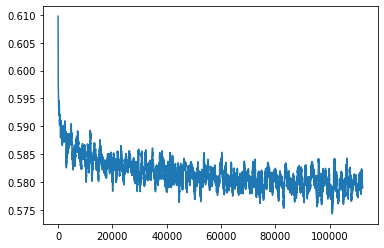

In [45]:
avg_train_losses = moving_average(train_losses, 500)

plt.plot(np.arange(len(avg_train_losses)), avg_train_losses)

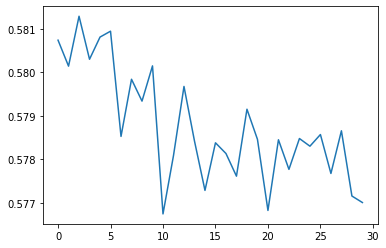

In [46]:
plt.plot(np.arange(len(test_losses)), test_losses)